In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
faces_path = "/content/drive/MyDrive/Colab Notebooks/Pattern/projects/data/faces"
nonfaces_path = "/content/drive/MyDrive/Colab Notebooks/Pattern/projects/data/nonFaces"

In [ ]:
import numpy as np
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from PIL import Image
from pylab import rcParams

## Loading The Data

In [ ]:
ROWS = 400
COLS = 10304

#initiating vectors
data = [[0 for i in range(COLS)] for i in range(ROWS)]
labels = [0 for i in range(ROWS)]

for i in range(40):
    j=0
    for j in range (10):
        img = Image.open( faces_path +'/s' + str(i+1)+'/'+str(j+1)+'.pgm' )

        # convert it to a matrix (vector)
        data[i*10+j] = np.matrix(np.array(img).ravel())

        #IDS Classes
        labels[i*10+j]=i+1


In [ ]:
#Converting the labels into an array
labels = np.array(labels)
data = np.array(data)
print(labels.shape)
print(data.shape)

(400,)
(400, 1, 10304)


### Split The Data

In [ ]:
#Odd rows for training and Even for testing
data_train = data.copy()[::2].reshape(ROWS//2, COLS)
data_test = data.copy()[1::2].reshape(ROWS//2, COLS)
labels_train = labels.copy()[::2]
labels_test = labels.copy()[1::2]
print("training data:", data_train.shape, " :: training labels:",labels_train.shape)
print("testing data:", data_test.shape, " :: testing labels:",labels_test.shape)

training data: (200, 10304)  :: training labels: (200,)
testing data: (200, 10304)  :: testing labels: (200,)


## PCA

In [ ]:
#Getting number of directions to be projected on
def get_Dim(eigen_values, alpha):
    total_variance = np.sum(eigen_values)
    fraction_variance = 0
    eigen_values_sum = 0
    r = 0
    while(fraction_variance < alpha):
        eigen_values_sum += eigen_values[r]
        fraction_variance = eigen_values_sum / total_variance
        r+=1
    return r

In [ ]:
def PCA(train, test, alphas):
  # compute the mean
  mean = np.mean(train, axis = 0)

  # center the data
  Z = train - mean

  # get the covariance matrix
  cov = np.cov(Z, rowvar=False, bias=True)

  # get the eigenvalues and eigenvectors
  eigen_values, eigen_vectors = np.linalg.eigh(cov)

  # get the needed dimension for each alpha
  alphas_dim = []
  for alpha in alphas:
      alphas_dim.append(get_Dim(np.flip(eigen_values, axis=0), alpha))

  print("alphas_dim :",alphas_dim)

  Z_test = test - mean

  eigen_vectors = np.flip(eigen_vectors, axis=1)

  proj_mats = []
  reduced_data_train = []
  reduced_data_test = []
  for i in range(0, len(alphas_dim)):
    proj_mats.append(eigen_vectors[:,0:alphas_dim[i]])
    reduced_data_train.append(np.matmul(proj_mats[i].transpose(), Z.transpose()))
    reduced_data_test.append(np.matmul(proj_mats[i].transpose(), Z_test.transpose()))
    print("proj_mat"+str(i)+":", proj_mats[i].shape)
    print("Reduced_data_train"+str(i)+":", reduced_data_train[i].shape)
    print("Reduced_data_test"+str(i)+":", reduced_data_test[i].shape)

  return {
      "centered_data":Z,
      "eigen_values":eigen_values,
      "eigen_vectors": eigen_vectors,
      "alphas_dim":alphas_dim,
      "proj_matrix": proj_mats,
      "reduced_data_train": reduced_data_strain,
      "reduced_data_test": reduced_data_test
  }

In [ ]:
alphas = [0.8, 0.85, 0.9, 0.95]
pca = PCA(data_train, data_test, alphas)

alphas_dim : [36, 51, 76, 115]
proj_mat0: (10304, 36)
Reduced_data_train0: (36, 200)
Reduced_data_test0: (36, 200)
proj_mat1: (10304, 51)
Reduced_data_train1: (51, 200)
Reduced_data_test1: (51, 200)
proj_mat2: (10304, 76)
Reduced_data_train2: (76, 200)
Reduced_data_test2: (76, 200)
proj_mat3: (10304, 115)
Reduced_data_train3: (115, 200)
Reduced_data_test3: (115, 200)


In [ ]:
# print("pca.centered_data ",pca["centered_data"])
# print("pca.eigen_values ",pca["eigen_values"])
# print("pca.eigen_vectors ",pca["eigen_vectors"])
# print("pca.alphas_dim ",pca["alphas_dim"])
# print("pca.proj_matrix ",pca["proj_matrix"])
# print("pca.reduced_data_train ",pca["reduced_data_train"])
# print("pca.reduced_data_test ",pca["reduced_data_test"])

### Faces plots:

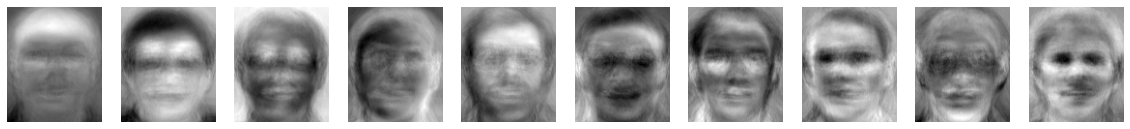

In [ ]:
#displaying the first 10 eigen vectors as images.(i.e. eigen face)

plt.rcParams["figure.figsize"] = [20.00, 5]

for i in range(0, 10):
    eigen_face = pca["eigen_vectors"][:,i].reshape(112,92)
    plt.subplot(1, 10, i+1)
    plt.imshow(eigen_face, cmap='gray');
    plt.axis('off')
plt.show()

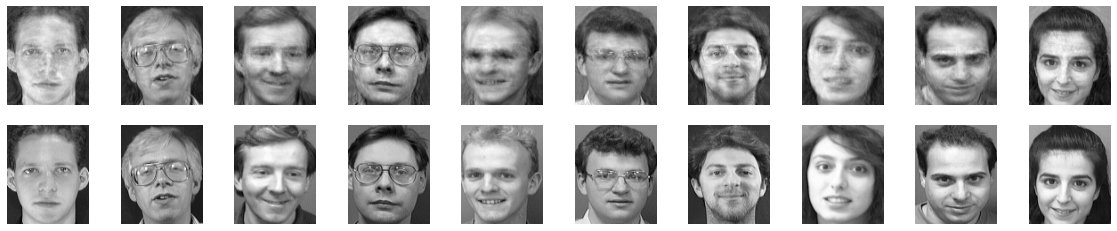

In [ ]:
# An example of a reconstructed image from the reduced data and the projection matrix (when alph = 0.95)
# to compare the reconstructed face and the original face.
plt.rcParams["figure.figsize"] = [20.00, 4]
fig, axs = plt.subplots(2, 10)

# reconstruction
re_faces = np.matmul(pca["reduced_data_train"][-1].T, pca["proj_matrix"][-1].T ) + np.mean(data_train, axis = 0)

for i in range(0, 50, 5):
    axs[0, i//5].imshow(re_faces[i].reshape(112,92), cmap='gray');
    axs[0, i//5].axis('off')
    axs[1, i//5].imshow(data_train[i].reshape(112,92), cmap='gray');
    axs[1, i//5].axis('off')
plt.show()

## KNN - PCA

In [ ]:
#PCA Nearest Neighbor runs KNN algorithms and returns accuracy depending on number of neighbors
def KNNPCA(data, proj_mat, numberOfNeighors):
    knn_pca = KNeighborsClassifier(n_neighbors = numberOfNeighors)
    knn_pca.fit(data.T, labels_train)
    mean = np.mean(data_test, axis=0)
    Z2 = data_test - mean
    newTestData = np.matmul(Z2, proj_mat)
    predicted_data = knn_pca.predict(newTestData)
    accuracy = metrics.accuracy_score(labels_test, predicted_data)
    return accuracy

In [ ]:
#Trying different values with KNN to see how the accuracy varies with the number of neighbors
KNNS = [1, 3, 5, 7]

accuracy_KNN1 = []
accuracy_KNN3 = []
accuracy_KNN5 = []
accuracy_KNN7 = []

for i in range(len(KNNS)):
    accuracy_KNN1.append(KNNPCA(pca["reduced_data_train"][i], pca["proj_matrix"][i], KNNS[0]))
    accuracy_KNN3.append(KNNPCA(pca["reduced_data_train"][i], pca["proj_matrix"][i], KNNS[1]))
    accuracy_KNN5.append(KNNPCA(pca["reduced_data_train"][i], pca["proj_matrix"][i], KNNS[2]))
    accuracy_KNN7.append(KNNPCA(pca["reduced_data_train"][i], pca["proj_matrix"][i], KNNS[3]))

### Plotting Alphas againist Accuracy:

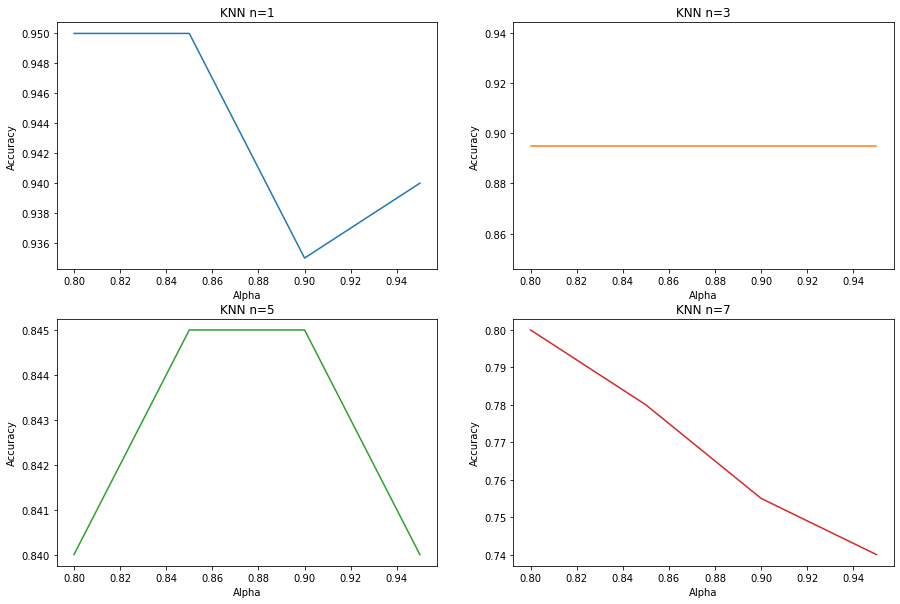

In [ ]:
fig, axs = plt.subplots(2, 2)
plt.rcParams["figure.figsize"] = [15, 10]

axs[0, 0].plot(alphas, accuracy_KNN1)
axs[0, 0].set_title('KNN n=1')

axs[0, 1].plot(alphas, accuracy_KNN3, 'tab:orange')
axs[0, 1].set_title('KNN n=3')

axs[1, 0].plot(alphas, accuracy_KNN5, 'tab:green')
axs[1, 0].set_title('KNN n=5')

axs[1, 1].plot(alphas, accuracy_KNN7, 'tab:red')
axs[1, 1].set_title('KNN n=7')

for ax in axs.flat:
    ax.set(xlabel='Alpha', ylabel='Accuracy')

### Plotting KNN Againist Accuracy:

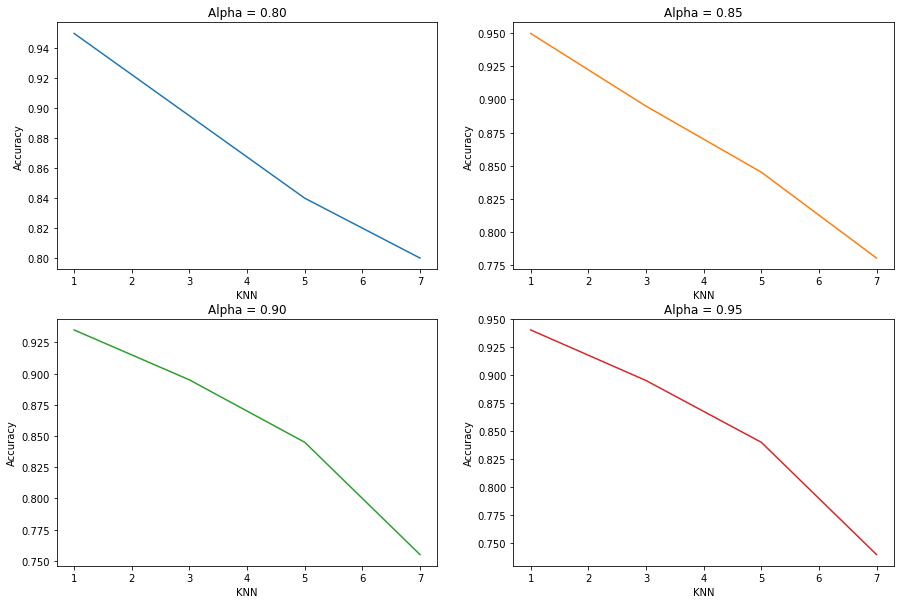

In [ ]:
fig, axs = plt.subplots(2, 2)
plt.rcParams["figure.figsize"] = [15, 10]

axs[0, 0].plot(KNNS, [ accuracy_KNN1[0], accuracy_KNN3[0], accuracy_KNN5[0], accuracy_KNN7[0]])
axs[0, 0].set_title('Alpha = 0.80')

axs[0, 1].plot(KNNS, [ accuracy_KNN1[1], accuracy_KNN3[1], accuracy_KNN5[1], accuracy_KNN7[1]], 'tab:orange')
axs[0, 1].set_title('Alpha = 0.85')

axs[1, 0].plot(KNNS, [ accuracy_KNN1[2], accuracy_KNN3[2], accuracy_KNN5[2], accuracy_KNN7[2]], 'tab:green')
axs[1, 0].set_title('Alpha = 0.90')

axs[1, 1].plot(KNNS, [ accuracy_KNN1[3], accuracy_KNN3[3], accuracy_KNN5[3], accuracy_KNN7[3]], 'tab:red')
axs[1, 1].set_title('Alpha = 0.95')

for ax in axs.flat:
    ax.set(xlabel='KNN', ylabel='Accuracy')

## LDA

In [ ]:
# mean per class
classified_data = np.split(data_train, 40)
mean_per_class = np.mean(classified_data , axis=1)
print(mean_per_class.shape)

(40, 10304)


In [ ]:
# Within class matrix
S = np.zeros((COLS, COLS))
for i in range(0, 40):
    S += np.dot((classified_data[i] - mean_per_class[i]).T,(classified_data[i] - mean_per_class[i]))
S_inv = np.linalg.inv(S)
print("S shape:", S.shape)
print("S inv shape:", S_inv.shape)

S shape: (10304, 10304)
S inv shape: (10304, 10304)


In [ ]:
# Overall mean of classes
total_mean = np.mean(data_train ,axis=0)
print(total_mean.shape)

(10304,)


In [ ]:
# Between class matrix
B = np.zeros((COLS, COLS))
for i in range(40):
  B += 5 * np.dot( (mean_per_class[i] - total_mean).T , (mean_per_class[i] - total_mean) )
print(B.shape)

(10304, 10304)


In [ ]:
# Getting Eigen vectors and values
mat = np.dot(B,S_inv)
eig_values_LDA, eig_vectors_LDA = np.linalg.eigh(mat)
print(eig_vectors_LDA.shape)

(10304, 10304)


In [ ]:
# Limiting to 39 dimensions
idx = eig_values_LDA.argsort()[-39:][::-1]
sortedEigVectMatrixLDA = np.real(eig_vectors_LDA[:,idx])

In [ ]:
# Getting the new train and test data
new_train_data = np.dot(data_train, sortedEigVectMatrixLDA)
new_test_data = np.dot(data_test, sortedEigVectMatrixLDA)

## KNN - LDA


In [ ]:
# KNN for LDA function that takes return accuracy depending on number of neighbors
def KNNLDA(new_train_data, numberOfNeighors):
    knn_lda = KNeighborsClassifier(n_neighbors=numberOfNeighors)
    knn_lda.fit(new_train_data,labels_train)
    predicted_data = knn_lda.predict(new_test_data)
    accuracy = metrics.accuracy_score(labels_test, predicted_data)
    return accuracy

In [ ]:
# Appending Different Accuracies Depending On No. Of Neighbors
LDA_accuracy = []
for i in range(len(KNNS)):
    LDA_accuracy.append(KNNLDA(new_train_data, KNNS[i]))

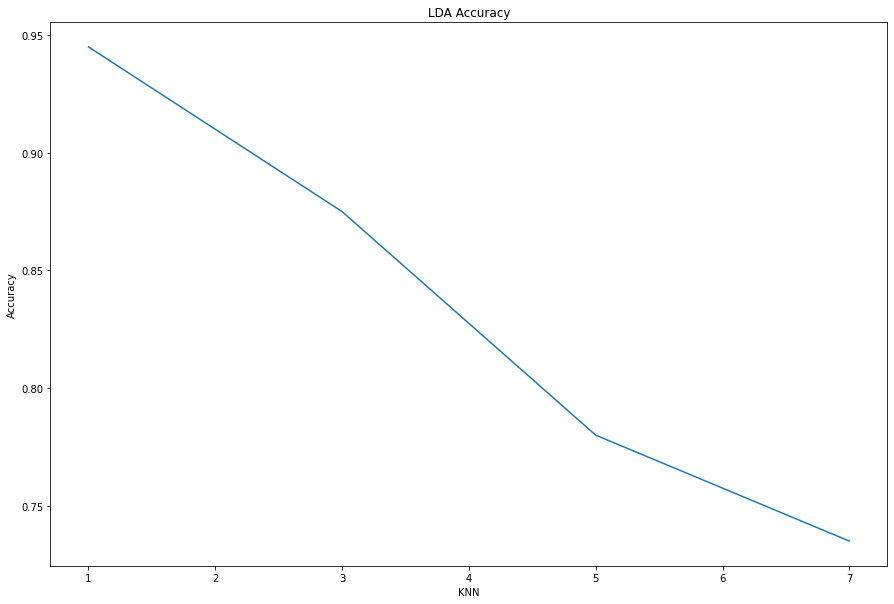

In [ ]:
# Plotting Accuracies Vs KNN
plt.plot(KNNS, LDA_accuracy)
plt.xlabel('KNN')
plt.ylabel('Accuracy')
plt.title('LDA Accuracy')
plt.show()



---



## Faces vs non faces
This dataset belongs to the Cifar-10 dataset that consists of airoplanes , boats , animals , etc...

### UsingPCA


In [ ]:
# Loading non-faces data
# 4000 Picture of different objects
items = ['airplane','ship','truck','horse']
ROWS = 4000
#initiating vectors
data_nonfaces = [[0 for i in range(COLS)] for i in range(ROWS)]
for i in range(len(items)):
  for j in range(1000):
    img = Image.open('/' + nonfaces_path + '/' + items[i] + '/' + str(j+1).zfill(4) + '.png' )
    img = img.convert('L')
    img = img.resize((92,112))
    # plt.imshow(img)
  # convert it to a matrix (vector)
    data_nonfaces[i*1000+j] = np.matrix(np.array(img).ravel())

In [ ]:
data_nonfaces = np.array(data_nonfaces)
labels_nonfaces = np.array([0 for i in range(ROWS)])
np.random.seed(42)
# Shuffling the non-faces data to mix the objects
np.random.shuffle(data_nonfaces)

In [ ]:
# Splitting the non-faces objects and labels into train and test
nonfaces_train = data_nonfaces.copy()[0:3800].reshape(3800, COLS)
nonfaces_test = data_nonfaces.copy()[3800::].reshape(200, COLS)
labels_nonfaces_train = labels_nonfaces.copy()[0:3800]
labels_nonfaces_test = labels_nonfaces.copy()[3800::]

print("nonfaces_train :", nonfaces_train.shape)
print("nonfaces_test :", nonfaces_test.shape)
print("labels_nonfaces_train : ", labels_nonfaces_train.shape)
print("labels_nonfaces_test : ", labels_nonfaces_test.shape)

nonfaces_train : (3800, 10304)
nonfaces_test : (200, 10304)
labels_nonfaces_train :  (3800,)
labels_nonfaces_test :  (200,)


In [ ]:
# A function plotting samples of success and faliure cases
def plot_case(data, labels, pred_labels, n):
  plt.rcParams["figure.figsize"] = [20.00, 5]
  fig, axs = plt.subplots(2, n)

  success_cases = np.where(labels == pred_labels)[0]
  failure_cases = np.where(labels != pred_labels)[0]
  np.random.shuffle(success_cases)
  np.random.shuffle(failure_cases)
  for i in range(0, n):
      axs[0, i].imshow(np.reshape(data[success_cases[i]], (112, 92)), cmap='gray')
      axs[0, i].set_title(f'True: {labels[success_cases[i]]}, Pred: {pred_labels[success_cases[i]]}')
      axs[0, i].axis('off')
      axs[1, i].imshow(np.reshape(data[failure_cases[i]], (112, 92)), cmap='gray')
      axs[1, i].set_title(f'True: {labels[failure_cases[i]]}, Pred: {pred_labels[failure_cases[i]]}')
      axs[1, i].axis('off')
  plt.show()

In [ ]:
# Knn function returns score and predicted labels and displays the confusion matrix
def knn(trainingSet, trainingLabel, testSet, testLabel, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(trainingSet, trainingLabel)
    pred = knn.predict(testSet)
    score = metrics.accuracy_score(testLabel, pred)
    confusion_matrix = metrics.confusion_matrix(testLabel, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    return {
        "score":score,
        "pred":pred
        }

In [ ]:
# We will take samples from this data and concatenate with the faces
# 1 --> faces       0 --> non faces
no_of_non_face_samples = [50, 200, 500, 1000, 3000]
accuracy_0_8 = []
accuracy_0_85 = []
accuracy_0_9 = []
accuracy_0_95 = []

In [ ]:
# Adding non-faces to faces in test
test = np.concatenate((data_test, nonfaces_test), axis = 0)
labels = np.concatenate((np.full((200), 1), labels_nonfaces_test))
print("test size: ", test.shape)
print("test labels size: ", labels.shape)

test size:  (400, 10304)
test labels size:  (400,)


#### 50 nonfaces

In [ ]:
# 50 non faces samples
label_train = np.concatenate((np.full((200), 1), labels_nonfaces_train[0:50]))
train200_50 = np.concatenate((data_train, nonfaces_train[0:50]) , axis = 0)

alphas = [0.8, 0.85, 0.9, 0.95]
pca50 = PCA(train200_50, test, alphas)

alphas_dim : [30, 44, 69, 117]
proj_mat0: (10304, 30)
Reduced_data_train0: (30, 250)
Reduced_data_test0: (30, 400)
proj_mat1: (10304, 44)
Reduced_data_train1: (44, 250)
Reduced_data_test1: (44, 400)
proj_mat2: (10304, 69)
Reduced_data_train2: (69, 250)
Reduced_data_test2: (69, 400)
proj_mat3: (10304, 117)
Reduced_data_train3: (117, 250)
Reduced_data_test3: (117, 400)


0.875


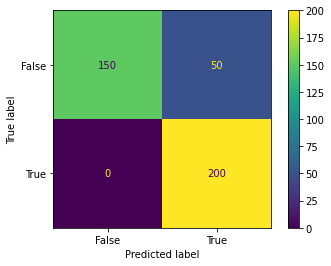

In [ ]:
knn50 = knn(pca50["reduced_data_train"][0].T ,label_train ,pca50["reduced_data_test"][0].T ,labels, 5)
accuracy_0_8.append(knn50["score"])
print(knn50["score"])

0.8775


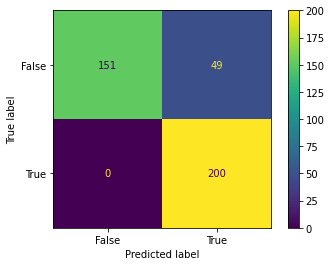

In [ ]:
knn50 = knn(pca50["reduced_data_train"][1].T ,label_train ,pca50["reduced_data_test"][1].T ,labels,5)
accuracy_S.append(knn50["score"])
print(knn50["score"])

0.8725


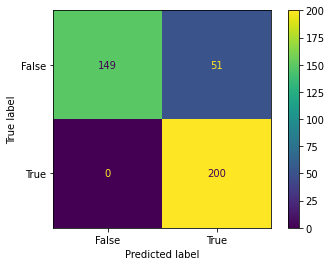

In [ ]:
knn50 = knn(pca50["reduced_data_train"][2].T ,label_train ,pca50["reduced_data_test"][2].T ,labels,5)
accuracy_0_9.append(knn50["score"])
print(knn50["score"])

0.8625


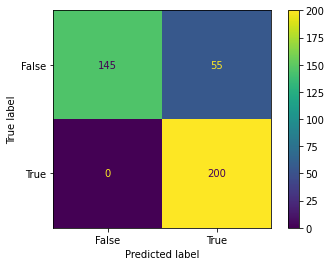

In [ ]:
knn50 = knn(pca50["reduced_data_train"][3].T ,label_train ,pca50["reduced_data_test"][3].T ,labels,5)
accuracy_0_95.append(knn50["score"])
print(knn50["score"])

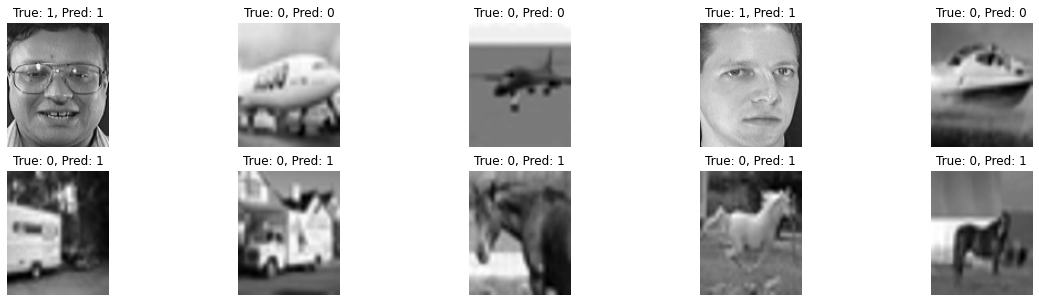

In [ ]:
plot_case(test,labels, knn50["pred"], 5)

#### 200 nonfaces

In [ ]:
# 200 non faces samples
label_train = np.concatenate((np.full((200), 1), labels_nonfaces_train[0:200]))
train200_200 = np.concatenate((data_train, nonfaces_train[0:200]) , axis = 0)

pca200 = PCA(train200_200, test, alphas)

alphas_dim : [24, 37, 61, 117]
proj_mat0: (10304, 24)
Reduced_data_train0: (24, 400)
Reduced_data_test0: (24, 400)
proj_mat1: (10304, 37)
Reduced_data_train1: (37, 400)
Reduced_data_test1: (37, 400)
proj_mat2: (10304, 61)
Reduced_data_train2: (61, 400)
Reduced_data_test2: (61, 400)
proj_mat3: (10304, 117)
Reduced_data_train3: (117, 400)
Reduced_data_test3: (117, 400)


0.9325


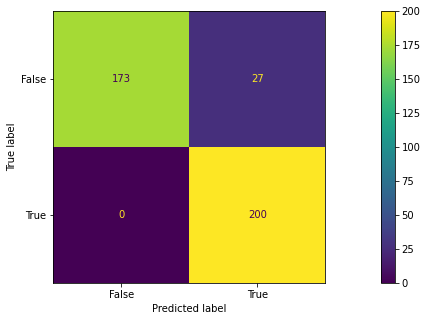

In [ ]:
knn200 = knn(pca200["reduced_data_train"][0].T ,label_train ,pca200["reduced_data_test"][0].T ,labels,5)
accuracy_0_8.append(knn200["score"])
print(knn200["score"])

0.9325


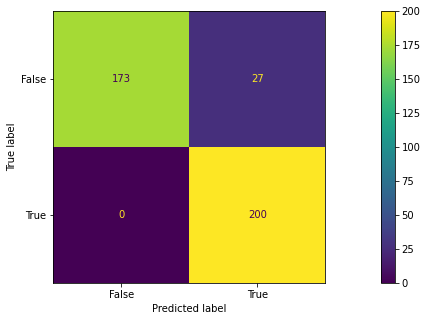

In [ ]:
knn200 = knn(pca200["reduced_data_train"][1].T ,label_train ,pca200["reduced_data_test"][1].T ,labels,5)
accuracy_0_85.append(knn200["score"])
print(knn200["score"])

0.935


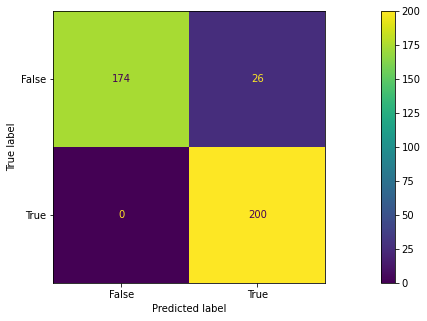

In [ ]:
knn200 = knn(pca200["reduced_data_train"][2].T ,label_train ,pca200["reduced_data_test"][2].T ,labels,5)
accuracy_0_9.append(knn200["score"])
print(knn200["score"])

0.9375


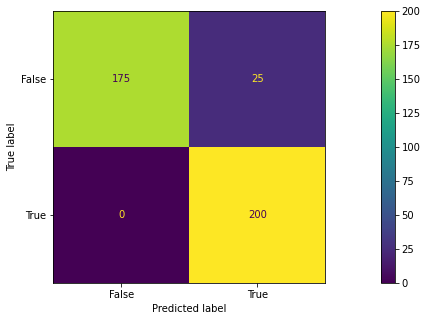

In [ ]:
knn200 = knn(pca200["reduced_data_train"][3].T ,label_train ,pca200["reduced_data_test"][3].T ,labels,5)
accuracy_0_95.append(knn200["score"])
print(knn200["score"])

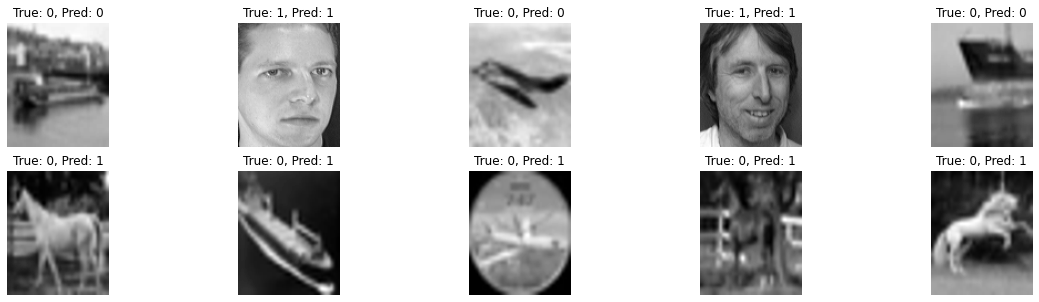

In [ ]:
plot_case(test,labels, knn200["pred"], 5)

#### 500 nonfaces

In [ ]:
# 500 non faces samples
label_train = np.concatenate((np.full((200), 1), labels_nonfaces_train[0:500]))
train200_500 = np.concatenate((data_train, nonfaces_train[0:500]) , axis = 0)

pca500 = PCA(train200_500, test, alphas)

alphas_dim : [24, 38, 64, 125]
proj_mat0: (10304, 24)
Reduced_data_train0: (24, 700)
Reduced_data_test0: (24, 400)
proj_mat1: (10304, 38)
Reduced_data_train1: (38, 700)
Reduced_data_test1: (38, 400)
proj_mat2: (10304, 64)
Reduced_data_train2: (64, 700)
Reduced_data_test2: (64, 400)
proj_mat3: (10304, 125)
Reduced_data_train3: (125, 700)
Reduced_data_test3: (125, 400)


0.96


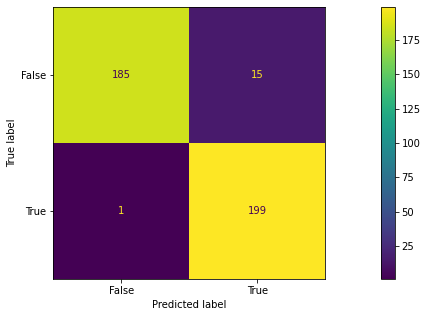

In [ ]:
knn500 = knn(pca500["reduced_data_train"][0].T ,label_train ,pca500["reduced_data_test"][0].T ,labels,5)
accuracy_0_8.append(knn500["score"])
print(knn500["score"])

0.9575


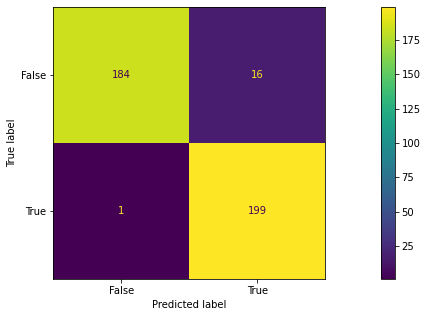

In [ ]:
knn500 = knn(pca500["reduced_data_train"][1].T ,label_train ,pca500["reduced_data_test"][1].T ,labels,5)
accuracy_0_85.append(knn500["score"])
print(knn500["score"])

0.95


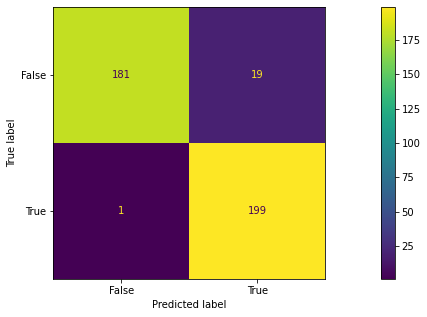

In [ ]:
knn500 = knn(pca500["reduced_data_train"][2].T ,label_train ,pca500["reduced_data_test"][2].T ,labels,5)
accuracy_0_9.append(knn500["score"])
print(knn500["score"])

0.9475


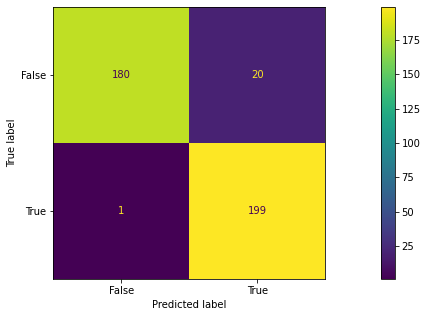

In [ ]:
knn500 = knn(pca500["reduced_data_train"][3].T ,label_train ,pca500["reduced_data_test"][3].T ,labels,5)
accuracy_0_95.append(knn500["score"])
print(knn500["score"])

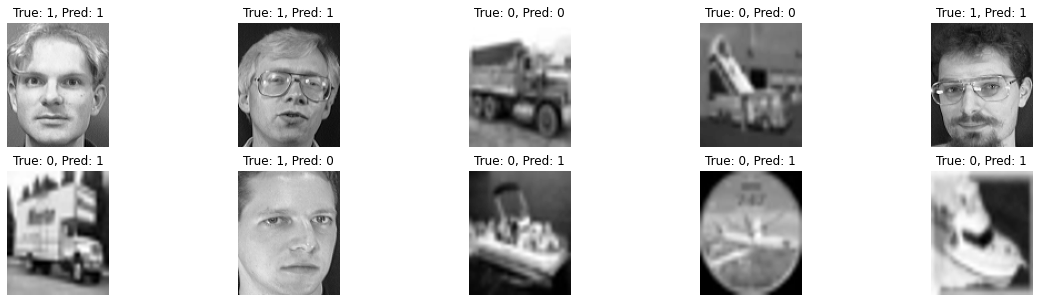

In [ ]:
plot_case(test,labels, knn500["pred"], 5)

#### 1000 nonfaces

In [ ]:
# 1000 non faces samples
label_train = np.concatenate((np.full((200), 1), labels_nonfaces_train[0:1000]))
train200_1000 = np.concatenate((data_train, nonfaces_train[0:1000]) , axis = 0)

pca1000 = PCA(train200_1000, test, alphas)

alphas_dim : [24, 38, 65, 130]
proj_mat0: (10304, 24)
Reduced_data_train0: (24, 1200)
Reduced_data_test0: (24, 400)
proj_mat1: (10304, 38)
Reduced_data_train1: (38, 1200)
Reduced_data_test1: (38, 400)
proj_mat2: (10304, 65)
Reduced_data_train2: (65, 1200)
Reduced_data_test2: (65, 400)
proj_mat3: (10304, 130)
Reduced_data_train3: (130, 1200)
Reduced_data_test3: (130, 400)


0.9675


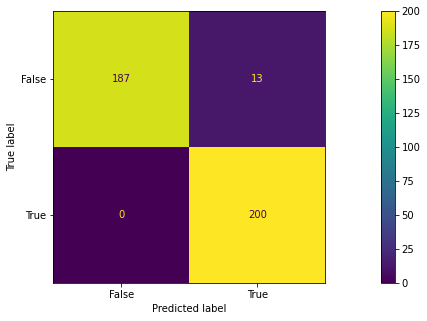

In [ ]:
knn1000 = knn(pca1000["reduced_data_train"][0].T ,label_train ,pca1000["reduced_data_test"][0].T ,labels,5)
accuracy_0_8.append(knn1000["score"])
print(knn1000["score"])

0.97


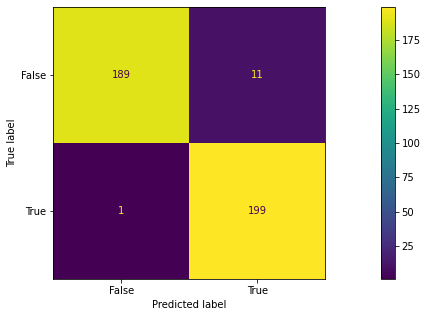

In [ ]:
knn1000 = knn(pca1000["reduced_data_train"][1].T ,label_train ,pca1000["reduced_data_test"][1].T ,labels,5)
accuracy_0_85.append(knn1000["score"])
print(knn1000["score"])

0.9625


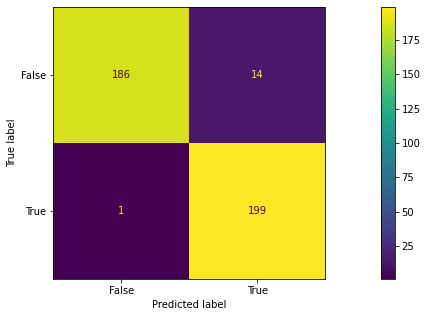

In [ ]:
knn1000 = knn(pca1000["reduced_data_train"][2].T ,label_train ,pca1000["reduced_data_test"][2].T ,labels,5)
accuracy_0_9.append(knn1000["score"])
print(knn1000["score"])

0.9625


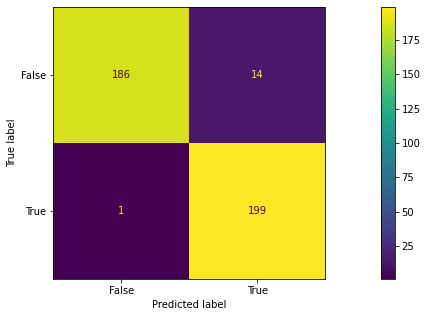

In [ ]:
knn1000 = knn(pca1000["reduced_data_train"][3].T ,label_train ,pca1000["reduced_data_test"][3].T ,labels,5)
accuracy_0_95.append(knn1000["score"])
print(knn1000["score"])

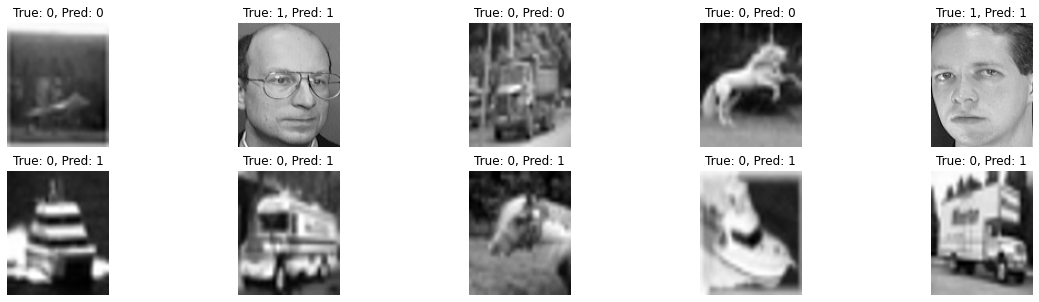

In [ ]:
plot_case(test,labels, knn1000["pred"], 5)

#### 3000 nonfaces

In [ ]:
# 3000 non faces samples
label_train = np.concatenate((np.full((200), 1), labels_nonfaces_train[0:3000]))
train200_3000 = np.concatenate((data_train,nonfaces_train[0:3000]) , axis = 0)

pca3000 = PCA(train200_3000, test, alphas)

alphas_dim : [25, 39, 67, 134]
proj_mat0: (10304, 25)
Reduced_data_train0: (25, 3200)
Reduced_data_test0: (25, 400)
proj_mat1: (10304, 39)
Reduced_data_train1: (39, 3200)
Reduced_data_test1: (39, 400)
proj_mat2: (10304, 67)
Reduced_data_train2: (67, 3200)
Reduced_data_test2: (67, 400)
proj_mat3: (10304, 134)
Reduced_data_train3: (134, 3200)
Reduced_data_test3: (134, 400)


0.9875


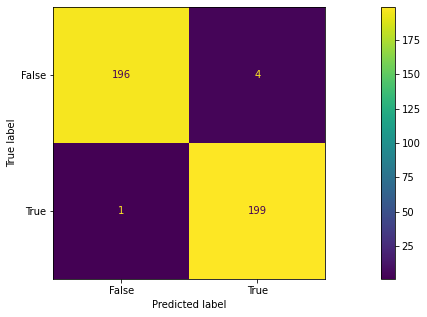

In [ ]:
knn3000 = knn(pca3000["reduced_data_train"][0].T ,label_train ,pca3000["reduced_data_test"][0].T ,labels,5)
accuracy_0_8.append(knn3000["score"])
print(knn3000["score"])

0.9875


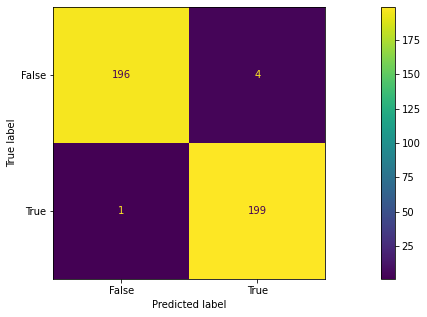

In [ ]:
knn3000 = knn(pca3000["reduced_data_train"][1].T ,label_train ,pca3000["reduced_data_test"][1].T ,labels,5)
accuracy_0_85.append(knn3000["score"])
print(knn3000["score"])

0.99


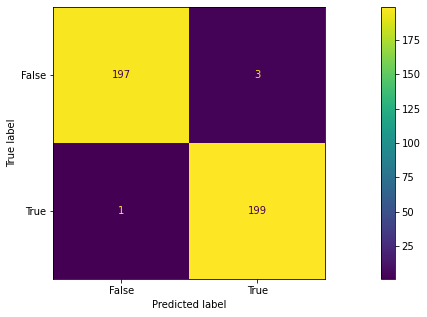

In [ ]:
knn3000 = knn(pca3000["reduced_data_train"][2].T ,label_train ,pca3000["reduced_data_test"][2].T ,labels,5)
accuracy_0_9.append(knn3000["score"])
print(knn3000["score"])

0.99


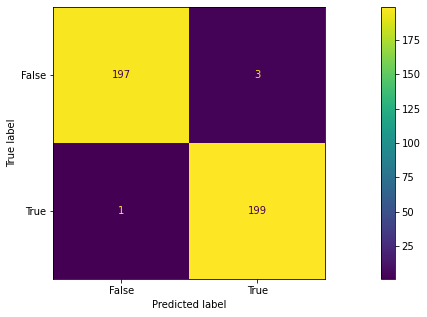

In [ ]:
knn3000 = knn(pca3000["reduced_data_train"][3].T ,label_train ,pca3000["reduced_data_test"][3].T ,labels,5)
accuracy_0_95.append(knn3000["score"])
print(knn3000["score"])

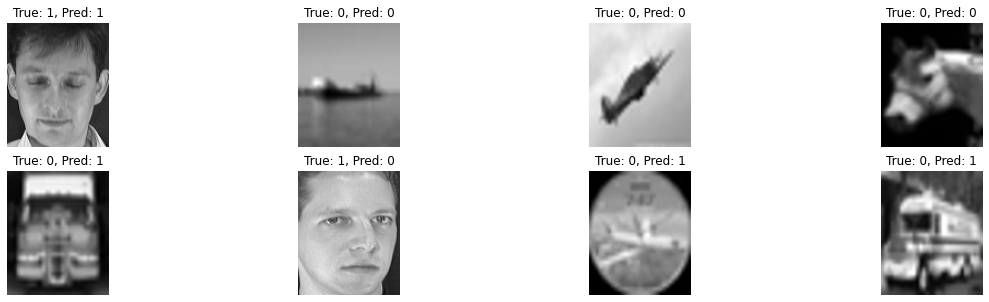

In [ ]:
plot_case(test,labels, knn3000["pred"], 4)


#### Plots

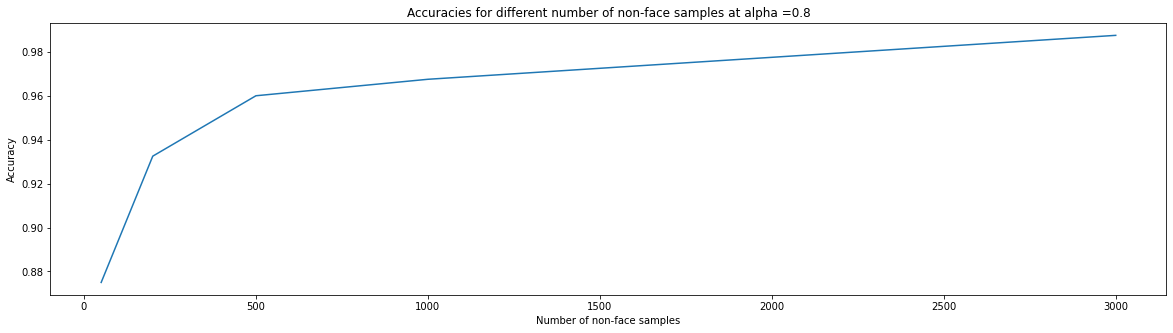

In [ ]:
x = [50,200,500,1000,3000]
y = accuracy_0_8
plt.plot(x, y)
plt.xlabel('Number of non-face samples')
plt.ylabel('Accuracy')
plt.title('Accuracies for different number of non-face samples at alpha =0.8')
plt.show()

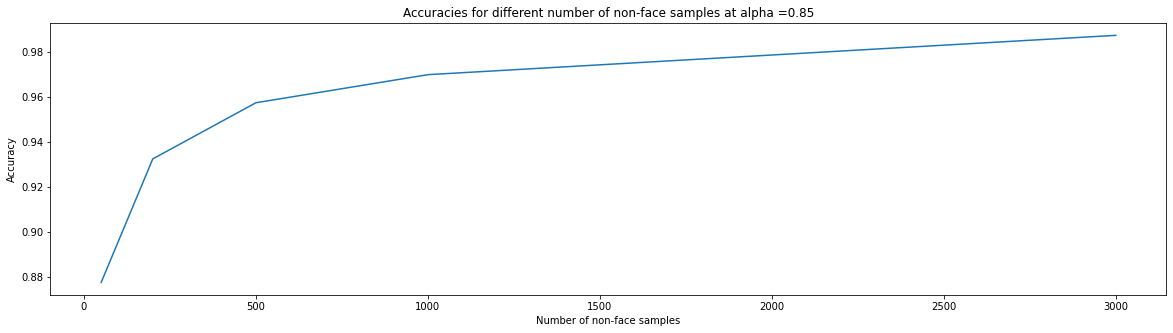

In [ ]:
x = [50,200,500,1000,3000]
y = accuracy_0_85
plt.plot(x,y)
plt.xlabel('Number of non-face samples')
plt.ylabel('Accuracy')
plt.title('Accuracies for different number of non-face samples at alpha =0.85')
plt.show()

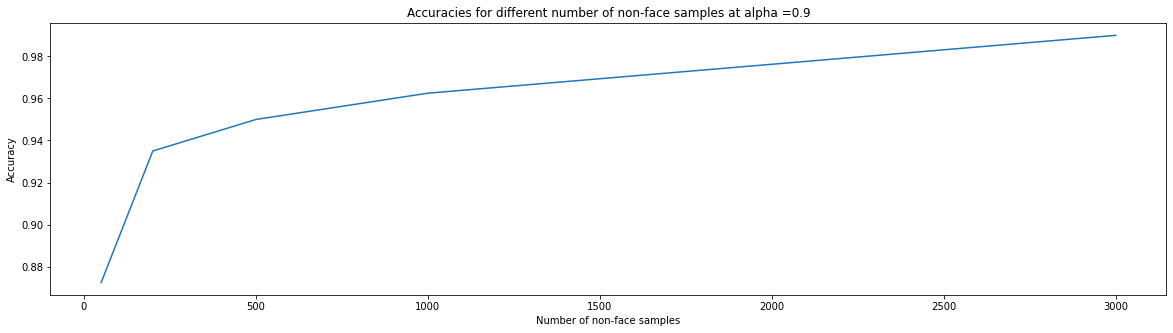

In [ ]:
x = [50,200,500,1000,3000]
y = accuracy_0_9
plt.plot(x,y)
plt.xlabel('Number of non-face samples')
plt.ylabel('Accuracy')
plt.title('Accuracies for different number of non-face samples at alpha =0.9')
plt.show()

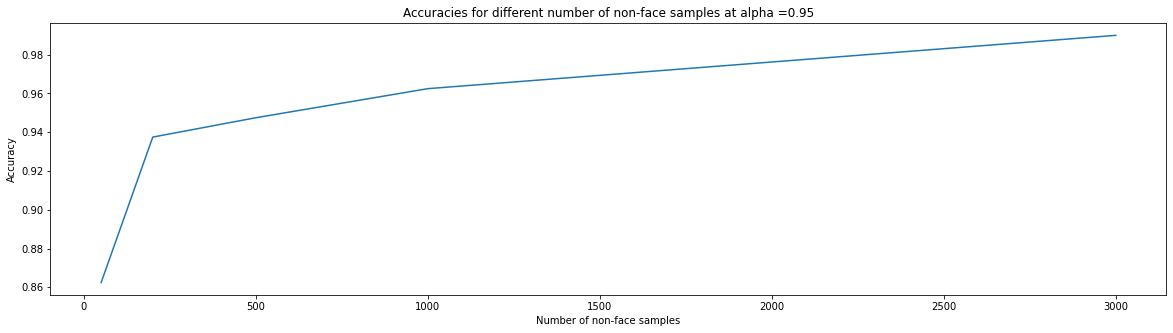

In [ ]:
x = [50,200,500,1000,3000]
y = accuracy_0_95
plt.plot(x,y)
plt.xlabel('Number of non-face samples')
plt.ylabel('Accuracy')
plt.title('Accuracies for different number of non-face samples at alpha =0.95')
plt.show()

### Using LDA

In [ ]:
# Function that assigns how many number of non-faces to 200 face in train set
def splitting_fVnf(sizeOfNonFaces):
  data_fVnf_train = np.concatenate((data_train.copy(), nonfaces_train.copy()[0: sizeOfNonFaces]))
  labels_fVnf_train = np.concatenate((np.full((200), 1), labels_nonfaces_train[0: sizeOfNonFaces]))
  return data_fVnf_train, test, labels_fVnf_train, labels

In [ ]:
# Initializations
data_fVnf_train = [0 for i in range(5)]
data_fVnf_test = [0 for i in range(5)]
labels_fVnf_train = [0 for i in range(5)]
labels_fVnf_test = [0 for i in range(5)]
new_train_data_fVnf = [0 for i in range(5)]
new_test_data_fVnf = [0 for i in range(5)]

accuracy = [0 for i in range(5)]
predicted_data = [0 for i in range(5)]

#### LDA-TEST

In [ ]:
# LDA using one dimension and returns the new train and test data
def LDAfVnf(data_fVnf_train,data_fVnf_test):
  classified_fVnf_data = np.split(data_fVnf_train,2)
  mean_per_class = np.mean(classified_fVnf_data , axis=1)
  # Within class matrix
  S = np.zeros((10304,10304))
  for i in range(2):
      S += np.dot((classified_fVnf_data[i] - mean_per_class[i]).T,(classified_fVnf_data[i] - mean_per_class[i]))
  S_inv = np.linalg.inv(S)
  #overall mean of classes
  total_mean = np.mean(data_train ,axis=0)
  B = np.dot((mean_per_class[0] - mean_per_class[1]).T , (mean_per_class[0] - mean_per_class[1]))
  mat = np.dot(B,S_inv)
  eig_values_LDA,eig_vectors_LDA = np.linalg.eigh(mat)
  idx = eig_values_LDA.argsort()[-1:][::-1]
  sortedEigVectMatrixLDA = np.real(eig_vectors_LDA[:,idx])
  new_train_data_fVnf = np.dot(data_fVnf_train,sortedEigVectMatrixLDA)
  new_test_data_fVnf = np.dot(data_fVnf_test,sortedEigVectMatrixLDA)
  return new_train_data_fVnf,new_test_data_fVnf

# KNN for LDA faces vs non-faces Returns accuracy and predicted data
def KNN_LDA_NONFACES (new_train_data_fVnf,new_test_data_fVnf,labels_fVnf_train,labels_fVnf_test,Accuracy,noOfNeighbours):
  knn_lda = KNeighborsClassifier(n_neighbors=1)
  knn_lda.fit(new_train_data_fVnf,labels_fVnf_train)
  predicted_data = knn_lda.predict(new_test_data_fVnf)
  Accuracy = metrics.accuracy_score(labels_fVnf_test, predicted_data)
  return Accuracy,predicted_data

#### Calculating LDA For All Splits

In [ ]:
'''
no_of_non_face_samples = [50,200,500,1000,3000]
0 --> 50-200 split
1 --> 200-200 split
2 --> 500-200 split
3 --> 1000-200 split
4 --> 3000-200 split
'''
for i in range(len(no_of_non_face_samples)):
  data_fVnf_train[i], data_fVnf_test[i], labels_fVnf_train[i], labels_fVnf_test[i] = splitting_fVnf(no_of_non_face_samples[i])
  new_train_data_fVnf[i], new_test_data_fVnf[i] = LDAfVnf(data_fVnf_train[i],data_fVnf_test[i])
  print('Split No:',i,'\n',no_of_non_face_samples[i],'- 200 -------------- Done')

Split No: 0 
 50 - 200 -------------- Done
Split No: 1 
 200 - 200 -------------- Done
Split No: 2 
 500 - 200 -------------- Done
Split No: 3 
 1000 - 200 -------------- Done
Split No: 4 
 3000 - 200 -------------- Done


#### Calculate Accuracy And Predicted Data For All Splits

In [ ]:
# Calculating Accuracies and Predicted data for different ratios of splits
for i in range(len(no_of_non_face_samples)):
  accuracy[i],predicted_data[i] = KNN_LDA_NONFACES(new_train_data_fVnf[i],new_test_data_fVnf[i],labels_fVnf_train[i],labels_fVnf_test[i],accuracy[i],1)
  print('Accuracy',no_of_non_face_samples[i],'- 200:',accuracy[i]*100,'%')

Accuracy 50 - 200: 50.24999999999999 %
Accuracy 200 - 200: 51.74999999999999 %
Accuracy 500 - 200: 58.25 %
Accuracy 1000 - 200: 84.25 %
Accuracy 3000 - 200: 91.75 %


**Confusion Matrix**

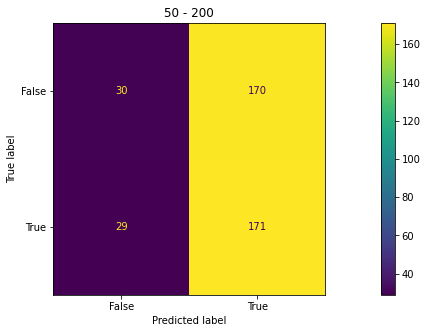

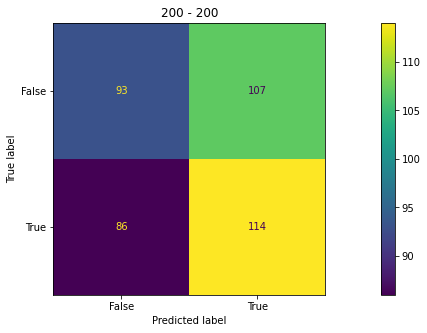

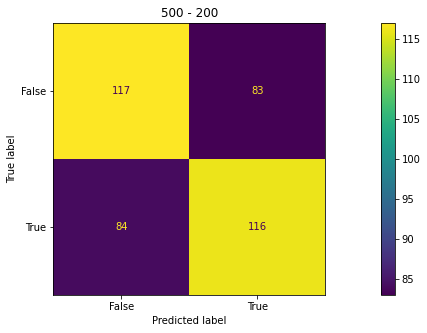

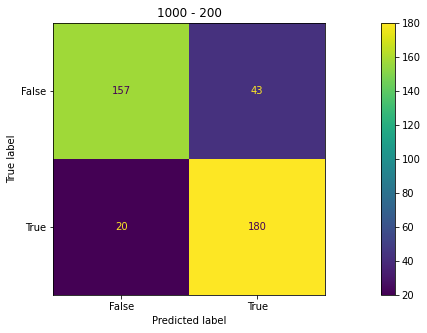

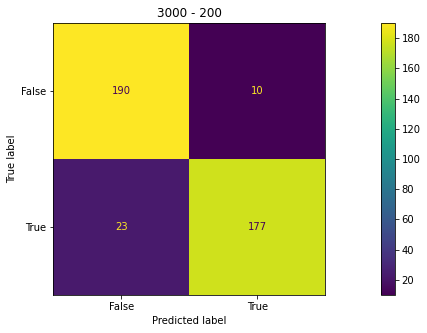

In [ ]:
# Displaying Confusion Matrix For All The Ratios
for i in range(len(no_of_non_face_samples)):
  confusion_matrix = metrics.confusion_matrix(labels_fVnf_test[i], predicted_data[i])
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
  cm_display.plot()
  plt.title(f'{no_of_non_face_samples[i]} - 200')
  plt.show()

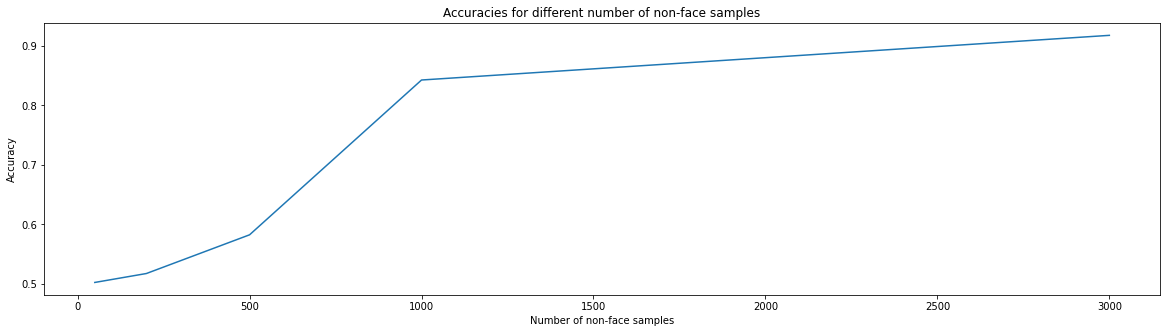

In [ ]:
# Plotting Different Number Of Non-Faces Samples With Accuracies
plt.plot(no_of_non_face_samples, accuracy)
plt.xlabel('Number of non-face samples')
plt.ylabel('Accuracy')
plt.title('Accuracies for different number of non-face samples')
plt.show()

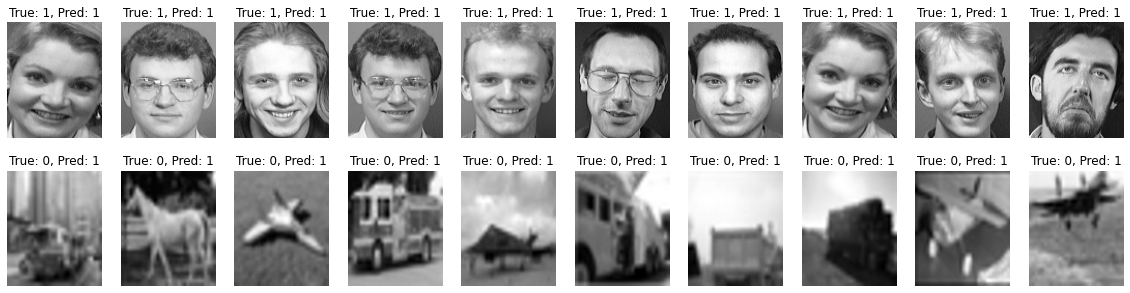

In [ ]:
# Accuracy 50 - 200: 50.24 %
plot_case(data_fVnf_test[0], labels_fVnf_test[0], predicted_data[0], 10)

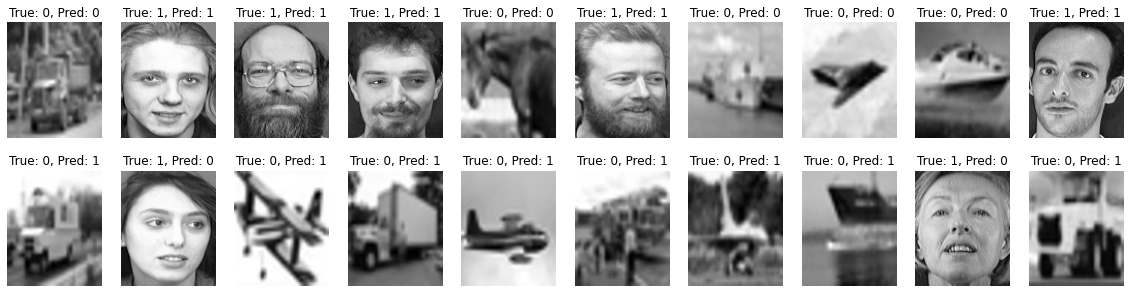

In [ ]:
# Accuracy 1000 - 200: 84.25 %
plot_case(data_fVnf_test[0], labels_fVnf_test[3], predicted_data[3], 10)

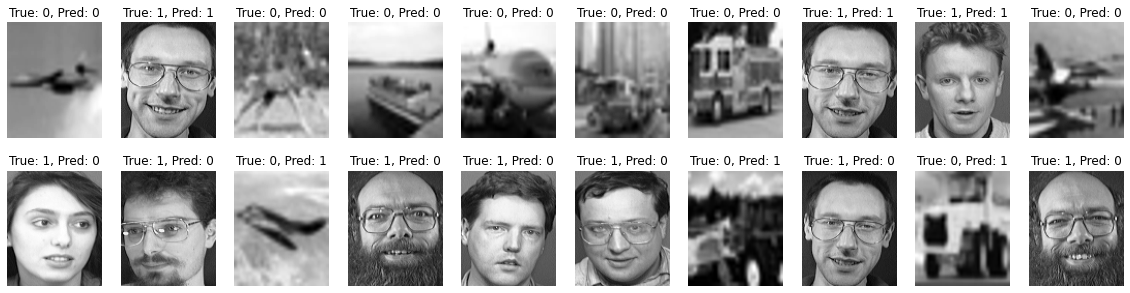

In [ ]:
# Accuracy 3000 - 200: 91.75 %
plot_case(data_fVnf_test[0], labels_fVnf_test[4], predicted_data[4], 10)



---

